# Kamień milowy 2

## Wczytanie odpowiednich bibliotek, wczytanie ramki danych

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

from pandas import json_normalize 
import requests

warnings.filterwarnings("ignore")

In [2]:
df=requests.get("https://api.apispreadsheets.com/api/dataset/gender-voice/").json()
from pandas import json_normalize 
voice_df = json_normalize(df, 'data')
voice_df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


## Pozbycie się kolumn które są w pełni zależne od innych kolumn (patrz EDA)

In [3]:
voice_df = voice_df.drop(columns=["centroid", "kurt", "dfrange"], axis=1)

In [4]:
voice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   sp.ent    3168 non-null   float64
 8   sfm       3168 non-null   float64
 9   mode      3168 non-null   float64
 10  meanfun   3168 non-null   float64
 11  minfun    3168 non-null   float64
 12  maxfun    3168 non-null   float64
 13  meandom   3168 non-null   float64
 14  mindom    3168 non-null   float64
 15  maxdom    3168 non-null   float64
 16  modindx   3168 non-null   float64
 17  label     3168 non-null   object 
dtypes: float64(17), object(1)
memory usage: 445.6+ KB


## Narysujmy rozkłady pozostałych kolumn

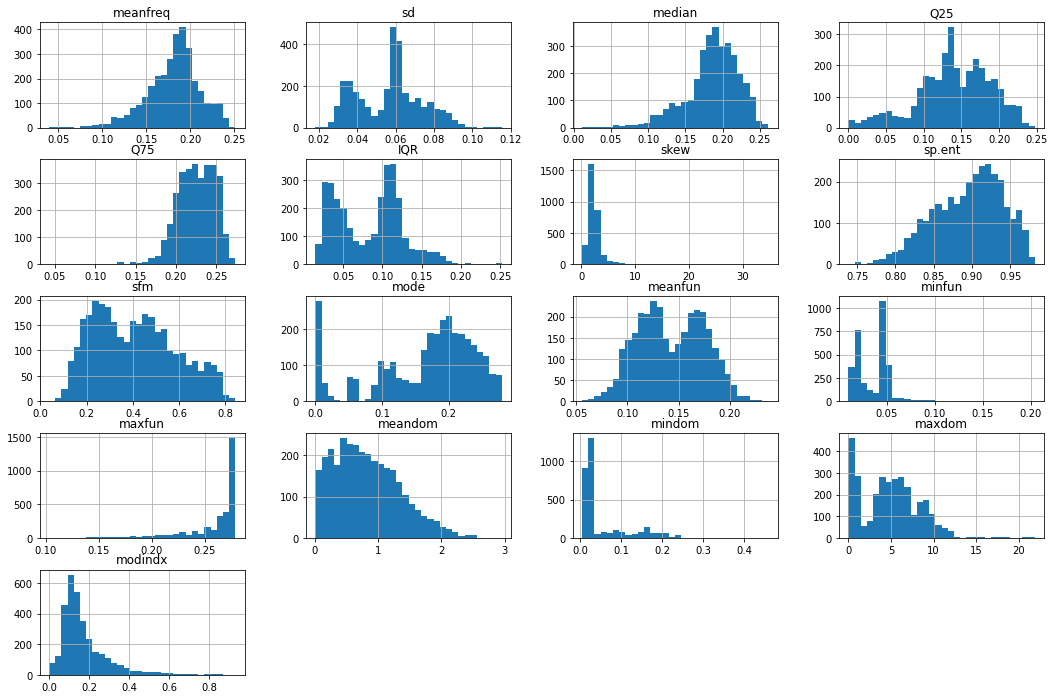

In [5]:
voice_df.hist(figsize=(18, 12), bins=30);
plt.show()

<Figure size 432x288 with 0 Axes>

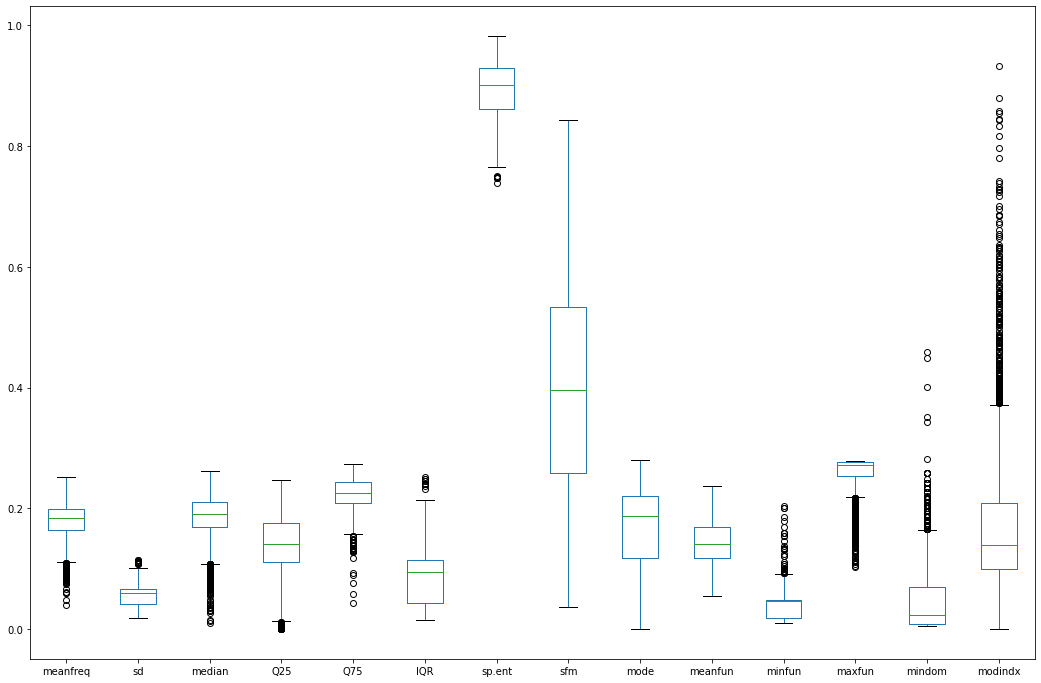

<Figure size 432x288 with 0 Axes>

In [6]:
voice_df.drop(columns=["skew", "meandom", "maxdom"], axis=1).plot(figsize=(18, 12), kind='box')
plt.figure()

<Figure size 432x288 with 0 Axes>

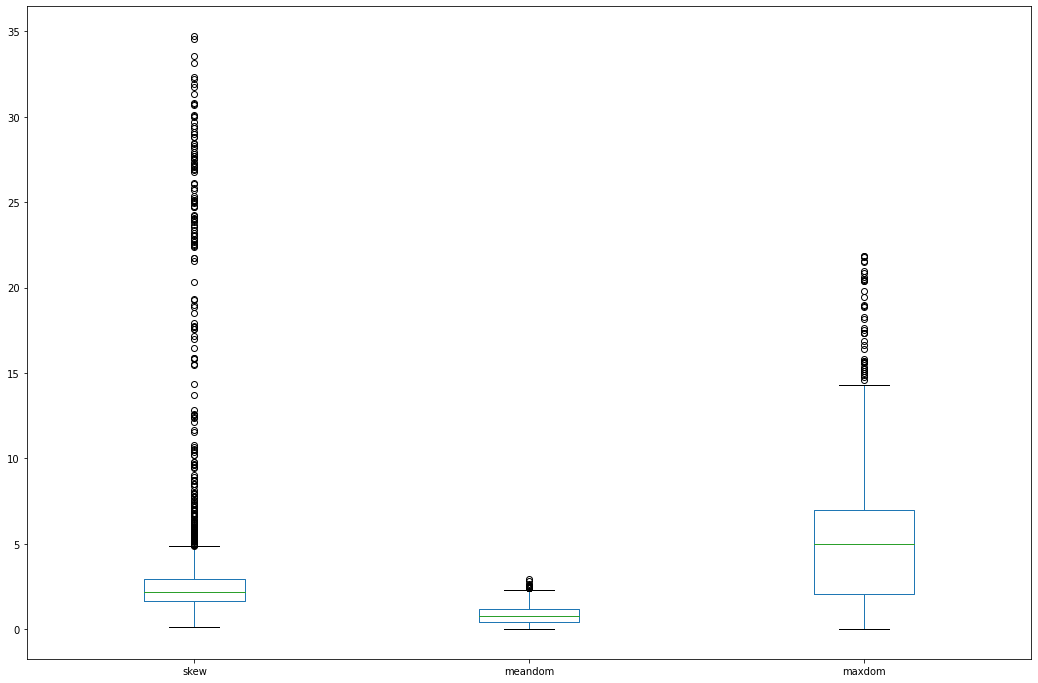

<Figure size 432x288 with 0 Axes>

In [7]:
voice_df[["skew", "meandom", "maxdom"]].plot(figsize=(18, 12), kind='box')
plt.figure()

### Przyjrzyjmy się kolumnie mindom. Mindom oznacza dokładnie minimal dominant frequency w trakcie trwanie dzwięku. Zauważmy, że większość z tych wartości jest zbliżona do zera. Odpowiada to dokładnie sytuacji, w której przez mikrofon nic nie mówiono. Jest to najprawdopodobniej charakterystyka otoczenia, co można zauważyć chociażby po następujących po sobie wierszach, w których wartości te są zbliżone do siebie. Z tego względu postanowiliśmy nie uwzględniać tej kolumny w dalszym budowaniu modelu

In [8]:
voice_df = voice_df.drop(columns=["mindom"], axis=1)

## Zauważmy, że kolumna skew oraz maxfun są prawo oraz lewo skośne. Dokonajmy odpowiednich transformacji

In [9]:
voice_df["skew"] = np.log1p(voice_df["skew"])
voice_df["modindx"] = np.log1p(voice_df["modindx"])

voice_df["maxfun"] = voice_df["maxfun"]**3

## Sprawdźmy, czy któryś z naszych rozkładów jest zbliżony do rozkładu normalnego

In [10]:
from scipy import stats

alpha =  0.05
cols = voice_df.columns.values
cols = cols[0:20]
cols_test = []
for col in cols:
    k2, p = stats.normaltest(voice_df.minfun)
    
    if p < alpha: 
        cols_test.append(0)
    else:
        cols_test.append(1)
print(cols_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Jak możemy zauważyć żadna z naszych zmiennych nie posiada rozkładu normalnego. Nie będziemy więc mogli się posłużyć metodami pozbywania się outlierów przeznaczonych dla rozkładów normalnych

### Przyjrzyjmy się kolumnie mode. Określa ona częstotliwość modalną. Zauważmy, że w bardzo wielu próbkach częstotliwość modalna wynosi zero, a co za tym idzie największą część częstotliwości głosu stanowiły momenty ciszy. Jednak nie zawsze oznacza to, że znacząca część nagrania stanowiła cisza. Ponieważ nie jesteśmy w stanie określić dokładnie na tak przerobionych danych ile dokładnie ona trwała, postanowiliśmy usunąć tylko i wyłącznie te wiersze, dla których Q25 wynosiło mniej niż 60Hz, gdyż to oznacza, że 25% czasu stanowiła cisza. 60Hz, gdyż głos męski zaczyna swoje częstotliwości w granicach 85Hz, także dodaliśmy jeszcze pewien gap, aby nie wyrzucić zbyt wiele wierszy

In [11]:
voice_df = voice_df[voice_df["Q25"] > 0.060]

In [12]:
voice_df

,meanfreq,sd,median,Q25,Q75,IQR,skew,sp.ent,sfm,mode,meanfun,minfun,maxfun,meandom,maxdom,modindx,label
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,0.803270,0.963322,0.727232,0.083878,0.088965,0.017798,0.015625,0.201497,0.562500,0.220836,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,0.742496,0.971955,0.783568,0.104261,0.106398,0.016931,0.018963,0.712812,5.484375,0.189193,male
5,0.132786,0.079557,0.119090,0.067958,0.209592,0.141634,1.075877,0.963181,0.738307,0.112555,0.110132,0.017112,0.016381,0.298222,2.726562,0.117925,male
6,0.150762,0.074463,0.160106,0.092899,0.205718,0.112819,0.928474,0.967573,0.762638,0.086197,0.105945,0.026230,0.018963,0.479620,5.312500,0.116887,male
7,0.160514,0.076767,0.144337,0.110532,0.231962,0.121430,0.874283,0.959255,0.719858,0.128324,0.093052,0.017758,0.002995,0.301339,0.539062,0.249931,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,0.203627,0.041529,0.204104,0.175661,0.239122,0.063461,0.901369,0.903458,0.246953,0.208821,0.146783,0.020566,0.018046,0.875558,6.898438,0.135870,female
3158,0.183667,0.040607,0.182534,0.156480,0.207646,0.051166,1.116497,0.898138,0.313925,0.177040,0.149237,0.018648,0.018046,0.550312,3.421875,0.154011,female
3159,0.168794,0.085842,0.188980,0.095558,0.240229,0.144671,0.901075,0.956201,0.706861,0.184442,0.182863,0.020699,0.019944,0.988281,5.882812,0.237927,female
3161,0.170656,0.081237,0.184277,0.113012,0.239096,0.126084,0.866367,0.950750,0.658558,0.161506,0.198475,0.160000,0.016381,0.414062,0.734375,0.290367,female


In [13]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
voice_df["label"] = encoder.fit_transform(voice_df[["label"]])

In [14]:
X = voice_df.drop(["label"], axis = 1)
y = voice_df[["label"]]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Wybór modelu

### Dokładność modeli porównywaliśmy na podstawie Accuracy oraz Area under curve. Zdecydowaliśmy się na wybranie ogólniejszej miary oceny klasyfikatora - accuracy, ponieważ nie interesuję nas tak naprawdę rozróżnienie FP od FN

### Dla wszystkich modeli  (dla których miało to sens) obliczyliśmy ważność zmiennych, przedstawiliśmy przykładową klasyfikacje oraz narysowaliśmy zmienną ROC

# SVM

In [16]:
from sklearn.svm import SVC
svm = SVC(probability=True)

svm.fit(X_train, y_train)
y_hat = svm.predict(X_test)
print('y:     ' + str(y_hat[0:10].tolist()) + '\ny_hat: ' + str(y_test["label"].tolist()[0:10]))

y:     [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
y_hat: [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [17]:
score = cross_val_score(svm, X, y, scoring='accuracy', cv = 10)
np.mean(score)

0.7396259944452291

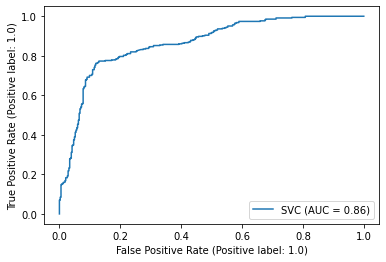

In [18]:
plot_roc_curve(svm, X_test, y_test);

In [19]:
roc_auc_score(y_test, svm.predict_proba(X_test)[:,1])

0.8635004530353367

# KNNeighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train, y_train)
y_hat = knn.predict(X_test)
print('y:     ' + str(y_hat[0:10].tolist()) + '\ny_hat: ' + str(y_test["label"].tolist()[0:10]))

y:     [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
y_hat: [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [21]:
score = cross_val_score(knn, X, y, scoring='accuracy', cv = 10)
np.mean(score)

0.7903532928494093

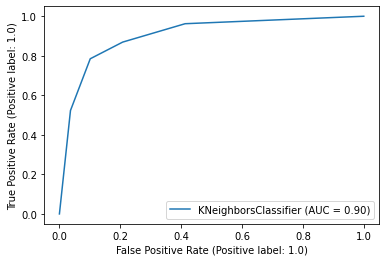

In [22]:
plot_roc_curve(knn, X_test, y_test);

In [23]:
roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])

0.9038772274237391

# Regresja logistyczna

In [24]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(max_iter=1000)

logistic_regression.fit(X_train,y_train)
y_hat = logistic_regression.predict(X_test)
print('y:     ' + str(y_hat[0:10].tolist()) + '\ny_hat: ' + str(y_test["label"].tolist()[0:10]))

y:     [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
y_hat: [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [25]:
score = cross_val_score(logistic_regression, X, y, scoring='accuracy', cv = 10)
np.mean(score)

0.91805888998729

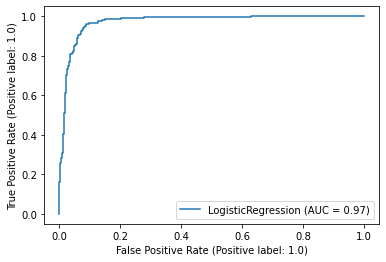

In [26]:
plot_roc_curve(logistic_regression, X_test, y_test);

In [27]:
roc_auc_score(y_test, logistic_regression.predict_proba(X_test)[:,1])

0.9725309574146783

In [19]:
importance = logistic_regression.coef_[0]
importance_df = pd.DataFrame(list(zip(X.columns.values, abs(logistic_regression.coef_[0]))),
               columns =['Variable', '|Coefficient|'])
importance_df.sort_values(by = "|Coefficient|", ascending = False, ignore_index = True)

,Variable,|Coefficient|
0,meanfun,16.065356
1,IQR,8.288698
2,Q25,5.467757
3,sp.ent,4.327213
4,Q75,2.820941
5,maxfun,2.258360
6,sd,1.502921
7,mindom,1.023748
8,median,0.841442
9,modindx,0.645621


# Naiwny Klasyfikator Bayesowski

In [28]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train, y_train)
y_hat = nb.predict(X_test)
print('y:     ' + str(y_hat[0:10].tolist()) + '\ny_hat: ' + str(y_test["label"].tolist()[0:10]))

y:     [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
y_hat: [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [29]:
score = cross_val_score(nb, X, y, scoring='accuracy', cv = 10)
np.mean(score)

0.9176928870686816

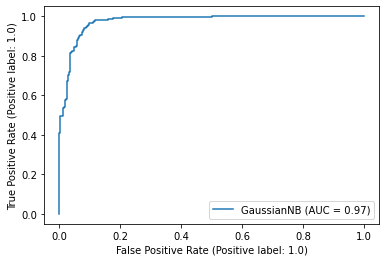

In [30]:
plot_roc_curve(nb, X_test, y_test);

In [31]:
roc_auc_score(y_test, nb.predict_proba(X_test)[:,1])

0.9746979764421624

# Drzewo decyzyjne

In [32]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(max_depth = 3)

tree.fit(X_train, y_train)
y_hat = tree.predict(X_test)
print('y:     ' + str(y_hat[0:10].tolist()) + '\ny_hat: ' + str(y_test["label"].tolist()[0:10]))

y:     [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
y_hat: [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [33]:
score = cross_val_score(tree, X, y, scoring='accuracy', cv = 10)
np.mean(score)

0.9540413312620627

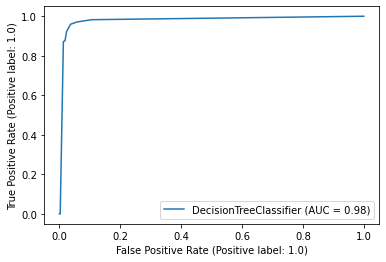

In [34]:
plot_roc_curve(tree, X_test, y_test);

In [35]:
roc_auc_score(y_test, tree.predict_proba(X_test)[:,1])

0.9799192086982784

In [36]:
import graphviz
from sklearn.tree import export_graphviz
import graphviz

dot_graph = export_graphviz(tree, feature_names = X.columns.values, impurity = False, class_names = ["Female", "Male"], label = "root", rounded = True)
    
graph = graphviz.Source(dot_graph)
graph.format = "jpg"
graph.render();

![](Source.gv.jpg)

In [37]:
name_list = []
importance_list = []
for name, importance in zip(X.columns, tree.feature_importances_):
    name_list.append(name)
    importance_list.append(importance)
    
importance_df = pd.DataFrame(list(zip(name_list, importance_list)),
               columns =['Variable', 'Importance'])
importance_df.sort_values(by = "Importance", ascending = False, ignore_index = True)

,Variable,Importance
0,meanfun,0.933238
1,IQR,0.056362
2,sfm,0.008436
3,median,0.001963
4,meanfreq,0.000000
5,sd,0.000000
6,Q25,0.000000
7,Q75,0.000000
8,skew,0.000000
9,sp.ent,0.000000


# Stackowanie (DecisionTree, NB, LogisticRegression)

In [38]:
from sklearn.ensemble import StackingClassifier

classifiers = [("DecisionTree", tree), ("NB", nb), ("LogisticRegression", logistic_regression)]

clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression())
clf.fit(X_train, y_train);

In [39]:
y_hat = clf.predict(X_test)
print('y:     ' + str(y_hat[0:10].tolist()) + '\ny_hat: ' + str(y_test["label"].tolist()[0:10]))

y:     [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
y_hat: [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [40]:
score = cross_val_score(clf, X, y, scoring='accuracy', cv = 10)
np.mean(score)

0.9578119851245116

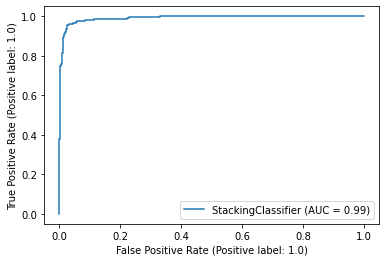

In [41]:
plot_roc_curve(clf, X_test, y_test);

In [42]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.9909694956206585

# XGBoost

In [43]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=2, learning_rate=0.1, booster='gbtree', nround = 100, max_depth=4, verbosity = 0);
xgb.fit(X_train, y_train);

In [44]:
y_hat = xgb.predict(X_test)
print('y:     ' + str(y_hat[0:10].tolist()) + '\ny_hat: ' + str(y_test["label"].tolist()[0:10]))

y:     [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
y_hat: [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [45]:
score = cross_val_score(xgb, X, y, scoring='accuracy', cv = 10)
np.mean(score)

0.969486419055689

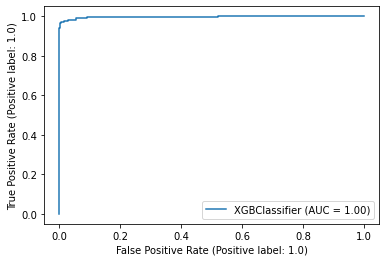

In [46]:
plot_roc_curve(xgb, X_test, y_test);

In [47]:
roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])

0.9961718514044094